In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from __future__ import print_function
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from scipy.stats import mode
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

In [2]:
def draw_contour(mask, rgb):
    if rgb.shape[0] != mask.shape[0]:
        x_, y_ = mask.shape[:2]
        rgb = cv2.resize(rgb, dsize=(y_, x_))
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, 0, (0,0,0), 5)
    return rgb2

def draw_contour_all(mask, rgb):
    mask = (mask != 6).astype(np.uint8)
    print(mask.shape, rgb.shape)
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
#     print(contours)
    rgb2 = np.copy(rgb)
    cv2.drawContours(rgb2, contours, -1, (0,0,0), 3)
    return rgb2

mask_list = glob.glob('../data/validation_svs/*png')
mask_paths = pd.DataFrame(mask_list, index=[os.path.basename(x).replace('.png', '') for x in mask_list])

# Evaluate performance

In [3]:
BACKGROUND = 255
def get_regions(mask, thresh=500):
#     label_images = {x: np.zeros_like(mask) for x in range(5)}
    label_images = []
    label_codes = []
    
    labels = np.unique(mask)
    image = (mask < BACKGROUND).astype(np.uint8)
    
    _, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
    for cnt_num, _ in enumerate(contours):
        dummy_image = np.zeros_like(mask)
        cv2.drawContours(dummy_image, contours, cnt_num, 1, -1)
        ## Check area -- 
        pos_area = dummy_image.sum()
        if pos_area < thresh:
            continue
        dummy_image = dummy_image.astype(np.bool)
        cnt_label = mode(mask[dummy_image])[0][0]
        label_images.append(np.copy(dummy_image))
        label_codes.append(cnt_label)
        
    return label_images, label_codes

In [4]:
## Test for the get_regions function
def test_get_regions():
    np.unique(mask)
    mask2 = np.copy(mask)
    mask2[10:100, 10:100] = 1
    mask2[110:150, 110:150] = 1
    label_images, label_codes = get_regions(mask2)

    for LI, LC in zip(label_images, label_codes): 
        plt.figure()
        plt.matshow(LI)
        plt.title(LC)

In [5]:
def perform_comparison(glob_path):
    inf_list = glob.glob(glob_path) # Where to glob for outputs
    print(len(inf_list))
    grade_dict = {0: 'G3', 1: 'G4', 2: 'G5', 3: 'BN', 4: 'ST'}; st_code=4; do_G5_shift=True

    # 4 class
#     grade_dict = {0: 'G3', 1: 'G4/G5', 2: 'BN', 3: 'ST'}; st_code=3; do_G5_shift=False
    attrib = ['Region', 'Slide', 'Region_area', 'TotalAcc', 'EpitheliumAcc', 
              'EpitheliumF1', 'Class_Label', 'Stroma_Area']
    attrib += ['{}'.format(x) for y,x in grade_dict.items()]
    performance = {k: [] for k in attrib}

    ## Reduce to slides we have annotated
    inf_bases = [os.path.basename(infp).replace('_prob.npy', '') for infp in inf_list]
    inf_list = [infp for infp, infb in zip(inf_list, inf_bases) if infb in mask_paths.index]
    print(len(inf_list))

    for idx, inf_path in enumerate(inf_list):
        inf_base = os.path.basename(inf_path).replace('_prob.npy', '')

        if inf_base not in mask_paths.index:
            print('{} no mask'.format(inf_base))
            continue

        mask = cv2.imread(mask_paths.loc[inf_base,0], -1)
        x = np.load(inf_path)
        x_, y_ = x.shape[:2]
        mask = cv2.resize(mask, dsize=(y_, x_), interpolation=cv2.INTER_NEAREST)
        label_images, label_codes = get_regions(mask)

        amax = np.argmax(x, axis=-1)
        amax[mask==255] = 255

        ## Loop over the present classes:
        region = 0
        for LI, LC in zip(label_images, label_codes):
            ## pull out annotated area
            amax_region = amax[LI]
            total_size = float(amax_region.shape[0])

            ## pull out non-stroma
            stroma_area = (amax_region == st_code).sum()
            amax_region = amax_region[amax_region != st_code]
            non_stroma_size = float(amax_region.shape[0])

            ## Reassign 2 --> 1 ( G5 / 4+5 --> G4 )
            if do_G5_shift:
                amax_region[amax_region == 2] = 1

            if LC == 2: LC = 1
            gt_region = np.zeros_like(amax_region) + LC
            total_acc = (amax_region == LC).sum() / total_size
            epithelium_acc = (amax_region == LC).sum() / non_stroma_size
            epithelium_f1 = f1_score(gt_region, amax_region, average='weighted')

            performance['Region'].append('{}_{:02d}'.format(inf_base, region))
            performance['Slide'].append(inf_base)
            performance['Region_area'].append(total_size)
            performance['TotalAcc'].append(total_acc)
            performance['EpitheliumAcc'].append(epithelium_acc)
            performance['EpitheliumF1'].append(epithelium_f1)
            performance['Class_Label'].append(grade_dict[LC])
            performance['Stroma_Area'].append(stroma_area)
            for co, gr in grade_dict.items():
                performance['{}'.format(gr)].append((amax_region == co).sum())
            print(idx, region, grade_dict[LC], inf_path, 'ACC:', epithelium_acc, 'F1:', epithelium_f1)
            region += 1

    perf_df = pd.DataFrame(performance, index=performance['Region'], columns=attrib[1:])
    outpath = os.path.join(os.path.split(inf_path)[0], 'processed_perf.csv')
    print(outpath)
    perf_df.to_csv(outpath, sep='\t')

In [9]:
# Generate a list "glob_paths", 
# modelname = 'unet_small'
# trainings = ['5x', '10x', '20x', '5x_FOV', '10x_FOV', '20x_FOV']
# trainings = ['10x_FOV', '20x_FOV']
# glob_paths = ['../{}/{}/inference/*.npy'.format(modelname, tx) for tx in trainings]

# or by typing them out:
glob_paths = [
    '../densenet_small/5x_FOV/inference/*.npy',
    '../densenet_small/10x_FOV/inference/*.npy',
    '../densenet_small/20x_FOV/inference/*.npy',
]
for glob_path in glob_paths:
    print(glob_path)
    perform_comparison(glob_path)

../densenet_small/5x_FOV/inference/*.npy
104
70
0 0 G3 ../densenet_small/5x_FOV/inference/1304706_prob.npy ACC: 0.7488097936975743 F1: 0.8563650505574281
0 1 G3 ../densenet_small/5x_FOV/inference/1304706_prob.npy ACC: 0.8016863775733684 F1: 0.8899288883486294
1 0 G3 ../densenet_small/5x_FOV/inference/1304732_prob.npy ACC: 0.7709665889730225 F1: 0.8706732174095995
2 0 G3 ../densenet_small/5x_FOV/inference/1304700_prob.npy ACC: 0.8009367201121329 F1: 0.889466810429923
3 0 G4 ../densenet_small/5x_FOV/inference/1305445_prob.npy ACC: 0.9480608002181173 F1: 0.9733379986004198
4 0 G3 ../densenet_small/5x_FOV/inference/1304716_prob.npy ACC: 0.5704008904985796 F1: 0.726439845965046
5 0 G3 ../densenet_small/5x_FOV/inference/1304715_prob.npy ACC: 0.637596609324358 F1: 0.7786980086474636
6 0 G3 ../densenet_small/5x_FOV/inference/1304717_prob.npy ACC: 0.6946252265731495 F1: 0.8197980481829746
7 0 G3 ../densenet_small/5x_FOV/inference/1304725_prob.npy ACC: 0.6969184581938646 F1: 0.8213929842399593
7

58 0 G3 ../densenet_small/5x_FOV/inference/1304720_prob.npy ACC: 0.5333463378158159 F1: 0.695663236233432
59 0 G4 ../densenet_small/5x_FOV/inference/1305460_prob.npy ACC: 0.5873929048770443 F1: 0.740072483721404
60 0 G3 ../densenet_small/5x_FOV/inference/1304701_prob.npy ACC: 0.9301121656600517 F1: 0.9637907912382654
61 0 G4 ../densenet_small/5x_FOV/inference/1305476_prob.npy ACC: 0.651063251579591 F1: 0.7886593695992099
61 1 G4 ../densenet_small/5x_FOV/inference/1305476_prob.npy ACC: 0.4334901479511829 F1: 0.6048038049940547
62 0 G4 ../densenet_small/5x_FOV/inference/1305494_prob.npy ACC: 0.35963568379167316 F1: 0.5290177186123006
63 0 G4 ../densenet_small/5x_FOV/inference/1305498_prob.npy ACC: 0.7553683588528753 F1: 0.8606380023239167
64 0 G4 ../densenet_small/5x_FOV/inference/1305479_prob.npy ACC: 0.7005007956010142 F1: 0.8238758810500099
65 0 G3 ../densenet_small/5x_FOV/inference/1304721_prob.npy ACC: 0.8211568981557489 F1: 0.9017969829917664
66 0 G4 ../densenet_small/5x_FOV/infere

45 0 G4 ../densenet_small/10x_FOV/inference/1305458_prob.npy ACC: 0.7205670011140768 F1: 0.8375924920651223
46 0 G4 ../densenet_small/10x_FOV/inference/1305454_prob.npy ACC: 0.5805977536568495 F1: 0.734655926612051
47 0 G3 ../densenet_small/10x_FOV/inference/1304712_prob.npy ACC: 0.7559423977791915 F1: 0.8610104736183387
48 0 G3 ../densenet_small/10x_FOV/inference/1304729_prob.npy ACC: 0.536073809717945 F1: 0.6979792329333175
49 0 G4 ../densenet_small/10x_FOV/inference/1305455_prob.npy ACC: 0.7015314223498228 F1: 0.8245882657647364
50 0 G4 ../densenet_small/10x_FOV/inference/1305483_prob.npy ACC: 0.5467954896993881 F1: 0.7070042463152708
51 0 G3 ../densenet_small/10x_FOV/inference/1304727_prob.npy ACC: 0.7100426766861705 F1: 0.8304385456182138
52 0 G4 ../densenet_small/10x_FOV/inference/1305487_prob.npy ACC: 0.7010112671528154 F1: 0.8242288345640194
52 1 G4 ../densenet_small/10x_FOV/inference/1305487_prob.npy ACC: 0.7193800693343507 F1: 0.8367900526064084
53 0 G4 ../densenet_small/10x_

35 0 G3 ../densenet_small/20x_FOV/inference/1304728_prob.npy ACC: 0.7857628848443613 F1: 0.8800304805448396
35 1 G3 ../densenet_small/20x_FOV/inference/1304728_prob.npy ACC: 0.8409739564752051 F1: 0.913618526234194
35 2 G3 ../densenet_small/20x_FOV/inference/1304728_prob.npy ACC: 0.6675009880121197 F1: 0.8006004108073946
35 3 G3 ../densenet_small/20x_FOV/inference/1304728_prob.npy ACC: 0.7256092751794305 F1: 0.8409890762831939
36 0 G4 ../densenet_small/20x_FOV/inference/1305481_prob.npy ACC: 0.7956664432063731 F1: 0.886207398057311
37 0 G3 ../densenet_small/20x_FOV/inference/1304709_prob.npy ACC: 0.7118368465254242 F1: 0.8316643586335516
38 0 G3 ../densenet_small/20x_FOV/inference/1304730_prob.npy ACC: 0.8794448019815366 F1: 0.9358559517729068
38 1 G3 ../densenet_small/20x_FOV/inference/1304730_prob.npy ACC: 0.7490711918867357 F1: 0.8565359664733913
39 0 G3 ../densenet_small/20x_FOV/inference/1304704_prob.npy ACC: 0.8312386143268496 F1: 0.9078430389394198
40 0 G4 ../densenet_small/20x_

In [53]:
perf_tables = glob.glob('../densenet_small/ext_*pct/inference/processed_perf.csv')
# perf_tables = glob.glob('../tfhub/inference/*/processed_perf.csv')
print(perf_tables)

for perf_tab in sorted(perf_tables):
    df = pd.read_csv(perf_tab, sep='\t', header=0, index_col=0)
    basename = os.path.split(perf_tab)[0]
    print(np.mean(df['EpitheliumF1']), basename, df.shape)

['../densenet_small/ext_10pct/inference/processed_perf.csv', '../densenet_small/ext_25pct/inference/processed_perf.csv', '../densenet_small/ext_75pct/inference/processed_perf.csv', '../densenet_small/ext_50pct/inference/processed_perf.csv']
0.7121440310310241 ../densenet_small/ext_10pct/inference (90, 12)
0.7794598850945145 ../densenet_small/ext_25pct/inference (90, 12)
0.8057039305166278 ../densenet_small/ext_50pct/inference (90, 12)
0.7704191765399112 ../densenet_small/ext_75pct/inference (90, 12)


In [58]:
pcts = [10,25,50,75]
# pt = ['../tfhub/inference/mobilenet_v2_050_224_{}pct/processed_perf.csv'.format(x) for x in pcts]
pt = ['../densenet_small/ext_{}pct/inference/processed_perf.csv'.format(x) for x in pcts]
F1s = []
for pt_, pct in zip(pt, pcts):
#     print p
    df = pd.read_csv(pt_, sep='\t', header=0, index_col=0)
    F1s.append(df['EpitheliumF1'].values)
    
sns.boxplot(data=F1s)
plt.xticks(range(len(pcts)), pcts, fontsize=14)
plt.ylabel('F1-Score', fontsize=16)
plt.xlabel('% Training data', fontsize=16)
plt.title('DenseNet-Small SSCNN', fontsize=20)

IOError: File ../tfhub/inference/mobilenet_v2_050_224_50pct/processed_perf.csv does not exist

In [29]:
df

,Slide,Region_area,TotalAcc,EpitheliumAcc,EpitheliumF1,Class_Label,Stroma_Area,G3,G4,G5,BN,ST
1304727_00,1304727,1222425.0,0.143167,0.337213,0.504352,G3,703433,175011,209407,0,134574,0
1305455_00,1305455,761694.0,0.277718,0.786601,0.880556,G4,492770,30128,211536,0,27260,0
1304700_00,1304700,449236.0,0.119169,0.665502,0.799161,G3,368793,53535,19590,0,7317,0
1305496_00,1305496,366869.0,0.418452,0.891106,0.942418,G4,194592,8946,153517,0,9814,0
1304718_00,1304718,41426.0,0.088399,0.227171,0.370236,G3,25306,3662,10647,0,1811,0
1305495_00,1305495,1785940.0,0.500418,0.942219,0.970250,G4,837417,19643,893716,0,35164,0
1304728_00,1304728,28796.0,0.074837,0.201515,0.335435,G3,18102,2155,6488,0,2051,0
1304728_01,1304728,16164.0,0.479770,0.758435,0.862625,G3,5939,7755,1890,0,580,0
1304728_02,1304728,52932.0,0.149248,0.406797,0.578331,G3,33512,7900,10350,0,1170,0
1304728_03,1304728,64633.0,0.033156,0.067682,0.126782,G3,32970,2143,24056,0,5464,0


# Plot performance

Text(0.5,1,'F1 \n U-Net-Small 5X Combined HighGrade')

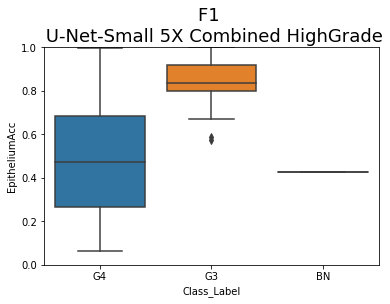

In [36]:
sns.boxplot(x="Class_Label", y="EpitheliumAcc", data=perf_df)
plt.ylim([0, 1.])

plt.title('F1 \n U-Net-Small 5X Combined HighGrade', fontsize=18)


# Draw masks into a figure

31
../tfhub/inference/inception_v3/1304732_prob.npy 1304732
(76, 116) [  0 255]
(76, 116) (76, 116, 3)


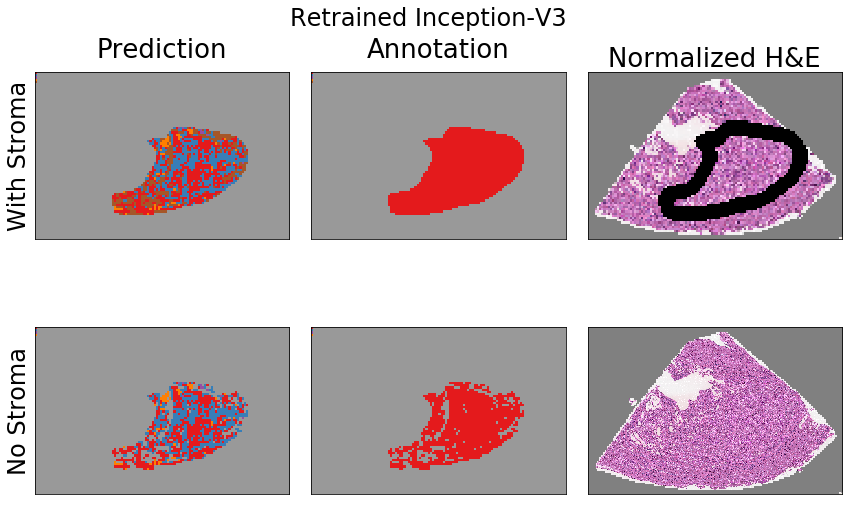

In [115]:
inf_list = glob.glob('../tfhub/inference/inception_v3/*npy')

# inf_list = glob.glob('../unet/10x/inference/*npy')

rgb_list = glob.glob('../unet/10x/inference/*rgb.jpg')

rgb_paths = pd.DataFrame(rgb_list, index=[os.path.basename(x).replace('_rgb.jpg', '') for x in rgb_list])
print(len(inf_list))

# inf_path = np.random.choice(inf_list,1)[0]
inf_path = '../tfhub/inference/inception_v3/1304732_prob.npy'
inf_base = os.path.basename(inf_path).replace('_prob.npy', '')
print(inf_path, inf_base)

x = np.load(inf_path)
mask = cv2.imread(mask_paths.loc[inf_base,0], -1)
rgb = cv2.imread(rgb_paths.loc[inf_base,0], -1)[:,:,::-1]
x_, y_ = x.shape[:2]
mask = cv2.resize(mask, dsize=(y_, x_), interpolation=cv2.INTER_NEAREST)
print(mask.shape, np.unique(mask))

fig, axs = plt.subplots(2,3,figsize=(12, 8))
    
amax = np.argmax(x, axis=-1)
## Take away unannotated area
amax[mask==255] = 6
mask[mask==255] = 6

mask[0:5, 0] = np.arange(5)
amax[0:5, 0] = np.arange(5)

axs[0][0].matshow(amax, cmap='Set1')
axs[0][0].set_yticks([])
axs[0][0].set_xticks([])
axs[0][0].set_title('Prediction', fontsize=26)
axs[0][0].set_ylabel('With Stroma', fontsize=24)

axs[0][1].matshow(mask, cmap='Set1')
axs[0][1].set_yticks([])
axs[0][1].set_xticks([])
axs[0][1].set_title('Annotation', fontsize=26)

rgb_marked = draw_contour(mask, rgb)
axs[0][2].imshow(rgb_marked)
axs[0][2].set_yticks([])
axs[0][2].set_xticks([])
axs[0][2].set_title('Normalized H&E', fontsize=26)

## Take away stroma
mask[amax==4] = 6
amax[amax==4] = 6

# rgb_marked = draw_contour_all(mask, rgb)

axs[1][0].matshow(amax, cmap='Set1')
axs[1][0].set_yticks([])
axs[1][0].set_xticks([])
axs[1][0].set_ylabel('No Stroma', fontsize=24)

axs[1][1].matshow(mask, cmap='Set1')
axs[1][1].set_yticks([])
axs[1][1].set_xticks([])

axs[1][2].imshow(rgb)
axs[1][2].set_yticks([])
axs[1][2].set_xticks([])

plt.tight_layout()
plt.suptitle('Retrained Inception-V3', fontsize=24)
plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/wsi_pred_label_inception_v3.pdf', bbox_inches='tight')